In [1]:
import torch
from torch_geometric.loader import DataLoader as GraphDataLoader
import matplotlib.pyplot as plt

import src.utils as utils
from src.models.gnn import GraphConvolutionalNetwork
from src.featurizers import GraphFeaturizer
from src.splitters import ScaffoldSplitter
from src.early_stopping import EarlyStopping
from src.grad_cam import plot_grad_cam_explanation, grad_cam


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
datasets = utils.load_data()
target_names = utils.get_data_target_field_names()

data, target_name = datasets[4], target_names[4]

splitter = ScaffoldSplitter()
train, test = splitter.train_test_molecules_split(data, target_name)

In [3]:
featurizer = GraphFeaturizer(y_col=target_name, log_target_transform=True)
graph_train = featurizer(train)
graph_test = featurizer(test)

batch_size = 64
graph_train_loader = GraphDataLoader(graph_train, batch_size, shuffle=True)
graph_test_loader = GraphDataLoader(graph_test, batch_size)

In [11]:
hidden_size = 512
n_layers = 4
model_path = "gnn4.pth"
gnn = GraphConvolutionalNetwork(graph_train[0].x.shape[1], hidden_size=hidden_size, n_layers=n_layers).to(device)
early_stopping = EarlyStopping(patience=20, min_delta=0.001)
gnn.train_model(graph_train_loader, graph_test_loader, epochs=9999, lr=0.001, early_stopping=early_stopping)
torch.save(gnn.state_dict(), model_path)

Epoch: 0, train loss: 9.4360, test loss: 4.1340
Epoch: 1, train loss: 4.5391, test loss: 4.7734
Epoch: 2, train loss: 4.6506, test loss: 4.0137
Epoch: 3, train loss: 4.5825, test loss: 4.1818
Epoch: 4, train loss: 4.5835, test loss: 4.5263
Epoch: 5, train loss: 4.6862, test loss: 3.9859
Epoch: 6, train loss: 4.3675, test loss: 4.1214
Epoch: 7, train loss: 4.3086, test loss: 3.9363
Epoch: 8, train loss: 4.1795, test loss: 3.9353
Epoch: 9, train loss: 4.2621, test loss: 4.0508
Epoch: 10, train loss: 4.1541, test loss: 4.2175
Epoch: 11, train loss: 4.1781, test loss: 3.9864
Epoch: 12, train loss: 4.0436, test loss: 4.2849
Epoch: 13, train loss: 4.0838, test loss: 4.4790
Epoch: 14, train loss: 4.1414, test loss: 4.0189
Epoch: 15, train loss: 4.0664, test loss: 4.3838
Epoch: 16, train loss: 4.0240, test loss: 3.8663
Epoch: 17, train loss: 3.8780, test loss: 4.1397
Epoch: 18, train loss: 3.9252, test loss: 4.3600
Epoch: 19, train loss: 3.8068, test loss: 4.2292
Epoch: 20, train loss: 3.9068,

In [4]:
hidden_size = 512
n_layers = 4
model_path = "gnn4.pth"
gnn = GraphConvolutionalNetwork(graph_train[0].x.shape[1], hidden_size=hidden_size, n_layers=n_layers).to(device)
gnn.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
gnn.r2_score(graph_test_loader)

0.48474550247192383

c:\Users\kamil\OneDrive\Pulpit\przedmioty\semestr 8\ml w lekach\projekt\src\grad_cam.py:55: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, y)


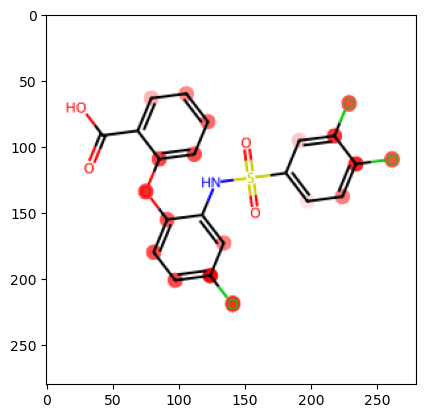

In [22]:
mol_index = 97
plot_grad_cam_explanation(gnn, test[mol_index], graph_test[mol_index])

In [ ]:
# explanations sparsity
grad_cam_weight_lists = []
for i in range(1000):
    grad_cam_weight_lists.append(grad_cam(gnn, graph_test[i]))

sparsity_scores = [len(weights[weights == 0]) / len(weights) for weights in grad_cam_weight_lists]

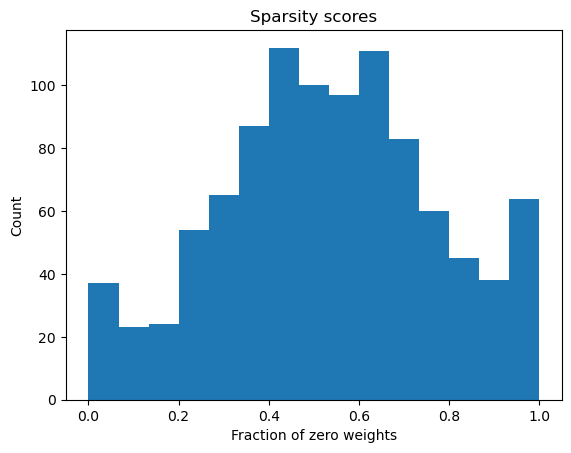

In [109]:
plt.hist(sparsity_scores, bins=15)
plt.title("Sparsity scores")
plt.xlabel("Fraction of zero weights")
plt.ylabel("Count")
plt.show()